In [1]:
import cvxpy as cp
import numpy as np

from copy import deepcopy

In [2]:
class OneTimeLearner:

    def __init__(self, epsilon, n, b):
        self.epsilon = epsilon
        self.n = n
        self.b = deepcopy(b)
        self.pi = []
        self.a = []
        self.x = []
        self.t = 0
        self.s = int(epsilon * n)
        self.p_hat = None
        self.allocation_check_rhs = deepcopy(b)

    def process_input(self, new_pi, new_a):
        
        # increment t and add new pi and a values
        self.t += 1
        self.pi.append(new_pi)
        self.a.append(new_a)

        if self.t <= self.s:
            new_x = 0
            if self.t == self.s:
                # solve LP to find p_hat using learning phase data
                
                # problem data
                cvx_a = np.array(self.a).T
                cvx_pi = np.c_[self.pi]
                cvx_b = np.c_[self.b]
                
                # construct the problem
                p = cp.Variable((len(self.b), 1))
                y = cp.Variable((self.s, 1))
                const = (1 - self.epsilon) * self.s / self.n 
                objective = cp.Minimize(const * cvx_b.T @ p + cp.sum(y))
                constraints = [cvx_a.T @ p + y >= cvx_pi, p >= 0, y >= 0]
                prob = cp.Problem(objective, constraints)
                prob.solve()
                self.p_hat = p.value.T.tolist()[0]  # save p
        else:            
            # determine allocation amount for the current bid
            allocation = 0
            rhs = 0
            for i in range(len(self.b)):
                rhs += self.p_hat[i] * self.a[-1][i]
            if self.pi[-1] > rhs:
                allocation = 1
            
            # determine whether to allocate towards the new bid 
            for i in range(len(self.b)):
                if allocation * self.a[-1][i] > self.allocation_check_rhs[i]:
                    new_x = 0
                    break
            else:
                new_x = allocation

        self.x.append(new_x)
        for i in range(len(self.b)):
            self.allocation_check_rhs[i] -= self.a[-1][i] * self.x[-1]
        return new_x
    
    def get_x(self):
        return self.x

In [7]:
M = 5
N = 10_000
EPS = [0.2, 0.15, 0.1, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]

one_time_rl = []

for eps in EPS:
    
    one_time_vals = []
    
    b_min = np.ceil(6 * M * np.log(N / eps) / (eps ** 3))
    b = [b_min] * M
    a = np.array([np.random.rand(N) for _ in b])
    pi = np.sum(np.random.rand(M, N) * a, axis=0) + np.random.normal(1, 0.1, N)
    
    # solve for optimal
    cvx_b = np.c_[b]
    cvx_pi = np.c_[pi]
    x = cp.Variable((N, 1))
    objective = cp.Maximize(cvx_pi.T @ x)
    constraints = [a @ x <= cvx_b, x >= 0, x <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    for _ in range(100):
        
        idx = np.random.permutation(N)
        
        a = a[:, idx]
        pi = pi[idx]

        alg = OneTimeLearner(eps, N, b)
        for i in range(N):
            alg.process_input(pi[i], list(a[:, i].T))
        one_time_vals.append(1 - pi.T @ np.c_[alg.get_x()] / prob.value)
    
    print("Done", eps)
    one_time_rl.append(np.average(one_time_vals))

Done 0.2
Done 0.15
Done 0.1
Done 0.07
Done 0.06
Done 0.05
Done 0.04
Done 0.03
Done 0.02


/home/colesturza/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done 0.01


In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

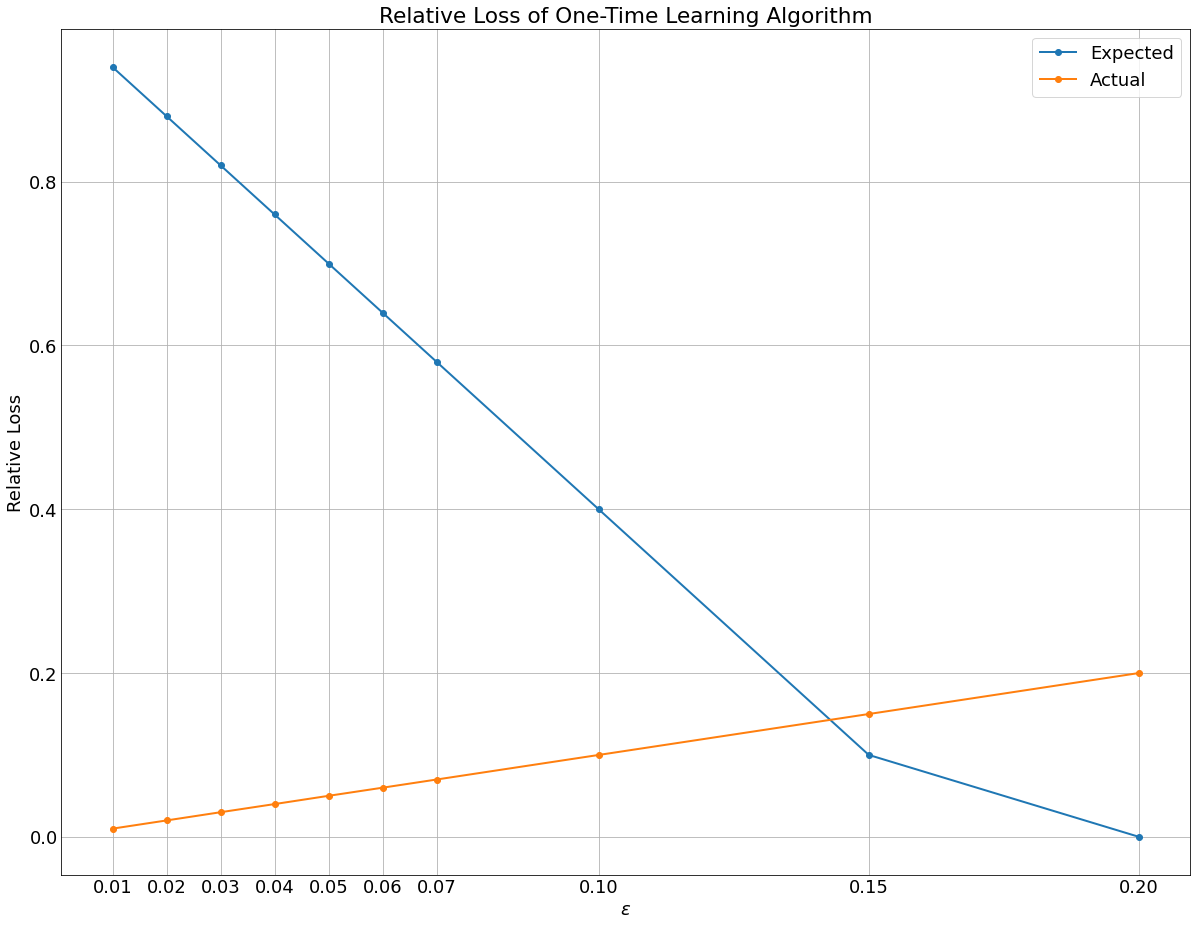

In [29]:
plt.style.use('_mpl-gallery')

epsilons = [0.2, 0.15, 0.1, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]

# plot
fig, ax = plt.subplots(figsize=(16, 12))

ax.plot(epsilons, [0] + [1 - (6 * eps) for eps in epsilons[1:]], "o-", linewidth=2.0, label="Expected")
ax.plot(epsilons, one_time_rl, "o-", linewidth=2.0, label="Actual")

ax.set(xticks=epsilons,
       title="Relative Loss of One-Time Learning Algorithm", 
       xlabel=r"$\epsilon$", 
       ylabel="Relative Loss",
)

plt.legend()

plt.show()